# INSURANCE PRODUCT PREDICTION IN NAKURU

##### Objective
This project aims to predict which clusters in Nakuru County would likely buy which insurance products. <br>
Its main objective is to aid insurance companies tailor their product marketing and advertising appropriately to groups most likely to buy them, increasing the probability of a sale.

##### Dataset
The dataset used for this project is the Kenya Financial Access Dataset 2021 from the Kenya National Bureau of Statistics.<br> The dataset is very big containing over 2000 columns.<br> To ensure only reliable attributes are used, the main dataframe used for this project is a sample from the original data.

##### Attributes
- HHNo - House Hold Number
- area - Area of residence(Urban/Rural)
- age_of_respondent - Age of Questionnaire Respondent
- chronic_illness - prence of chronically ill person in the house hold
- nhif_usage - Whether the house hold has ever/currently use NHIF
- nssf_usage -  Whether the house hold has ever/curently use NSSF
- most_important_life_goal - Main goal of the house hold
- income_source - Main income source of the house hold
- total_exp_per_month - Total monthly expenditure of the house hold
- avg_mnth_income - Average monthly income of the house hold
- hse_land_loan - Taken a loan to purchase house or land
- insurance_usage, insurance_usage1, and insurance_usage2 - Usage of differnet insurance products(was not specific)
- securities_use - Has invested in securities(Green Bond, Treasury Bill, M-Akiba)
- nearest_financial_prod - Nearest financial product(Bank, Sacco, Insurance, etc) 
- TV_and_decoder - Owns a TV and Decoder
- internet_TV - Owns an internet TV
- mobile_phone - Owns a mobile phone
- fixed_internet - Has fixed internet 
- computer - Owns a computer
- refrigerator - Owns a refrigerator
- motorcycle - Owns a motorcycle
- car - Owns a car
- bus_lorry - Owns a bus or lorry
- motorboat - Owns a motorboat
- tuktuk - Owns a tuktuk
- tractor - Owns a tractor
- dairy_cattle - Rears dairy cattle
- beef_cattle - Rears beef cattle
- indigenous_cattle - Rears indigenous cattle
- sheep - Rears Sheep
- goats - Rears goats
- land_house_ownership - Owns land or a house


### Imports

In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import lightgbm as lgb
import joblib
import os
import contextlib


from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier 



### Data Loading

In [2]:
#load data
df_samples = pd.read_excel('Updated Anonymized Weighted FinAccess 2021.xlsx')
df_samples.head()

,Serial Number,County,ClusterNo,HHNo,interview__key,interview__id,A9,A9i,A10i,A14v,...,allotherformal_banked2022,formal_banked2022,excluded_informal_banked2022,NHIF_health_insurance,NHIF_ONLY,Medical_Insurance_ONLY,BothNHIF_medical,Nomedical,NHIFMedical_Cat,adults
0,1,Trans Nzoia,10226038,1048,10-67-89-46,0003fc74b3fe418ea041bd6a9e7ff387,Rural,Access granted,Female,1,...,Yes,No,Other Formal,Yes,NaN,NaN,1.0,NaN,Users of NHIF + medical insurance (C1_42 and C...,1 adult Household
1,2,Busia,10240034,1080,39-64-68-81,0004890b17744272baf0a0c7b4c20771,Rural,Access granted,Female,4,...,No,Yes,Banked,Yes,1.0,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",>1 adult Household
2,3,Machakos,10216062,1013,92-34-74-01,00052153fe8c4abaa189caadcb87b2b4,Rural,Access granted,Male,1,...,No,No,Excluded,Yes,1.0,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",1 adult Household
3,4,Kisumu,10242078,1026,08-14-22-63,000d1f8747194b6a84862830dc5fe7ca,Rural,Access granted,Male,5,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
4,5,Nyeri,10219138,1019,99-12-05-84,000f5a5c0e3246ac9a62603ad936e3da,Urban,Access granted,Male,3,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household


### Data Preparation

In [3]:
#select data from nakuru county

nakuru  = df_samples[df_samples['County'] == 'Nakuru']
nakuru.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 48 to 22019
Columns: 2332 entries, Serial Number to adults
dtypes: float64(206), int64(76), object(2050)
memory usage: 14.3+ MB


In [4]:
nakuru.head()

,Serial Number,County,ClusterNo,HHNo,interview__key,interview__id,A9,A9i,A10i,A14v,...,allotherformal_banked2022,formal_banked2022,excluded_informal_banked2022,NHIF_health_insurance,NHIF_ONLY,Medical_Insurance_ONLY,BothNHIF_medical,Nomedical,NHIFMedical_Cat,adults
48,49,Nakuru,10232202,1090,95-50-72-90,00a5d78402974eca9eb2f0e2bfb2df3b,Urban,Access granted,Female,5,...,No,No,Excluded,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
180,181,Nakuru,10232130,1067,37-30-21-49,0265fd66b5e249809eb93a6f242d1bfa,Urban,Access granted,Female,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
188,189,Nakuru,10232034,1012,76-74-21-49,0279d89f2bc4492db64a821d217afb8c,Rural,Access granted,Male,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
213,214,Nakuru,10232066,1032,46-66-78-61,02c2c43d1fd84b3ab574d312d2af93f7,Rural,Access granted,Male,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household
227,228,Nakuru,10232214,1023,29-48-44-55,030ab71056c44f17a55bff4ae8a20c2f,Urban,Access granted,Male,2,...,No,Yes,Banked,No,NaN,NaN,NaN,"Users of NHIF only, with no medical insurance",None users of any of NHIF and medical insurance,>1 adult Household


#### Data Cleaning and Preprocessing

In [5]:
#check null values
nakuru[nakuru.columns].isnull().sum()

Serial Number               0
County                      0
ClusterNo                   0
HHNo                        0
interview__key              0
                         ... 
Medical_Insurance_ONLY    799
BothNHIF_medical          802
Nomedical                 214
NHIFMedical_Cat             0
adults                      0
Length: 2332, dtype: int64

In [6]:
#drop columns with more than 3/4 of values missing
threshold = len(nakuru) * 0.75

nakuru = nakuru.dropna(thresh=threshold, axis=1)
nakuru.isnull().sum()

Serial Number                   0
County                          0
ClusterNo                       0
HHNo                            0
interview__key                  0
                               ..
formal_banked2022               0
excluded_informal_banked2022    0
NHIF_health_insurance           0
NHIFMedical_Cat                 0
adults                          0
Length: 777, dtype: int64

In [7]:
#reset index
nakuru = nakuru.reset_index()
nakuru.drop(columns='index', inplace=True)

Select features to be used:

In [8]:
nakuru_df = nakuru[['HHNo', 'A9', 'A19', 'A24','nhif_usage', 'nssf_usage','insurance_usage','insurance_usage1','insurance_usage2','B1A', 'B3B', 'B3I', 'C1_4', 'C1_5', 'C1_6', 'T1', 'U16__3', 'U16__4', 'U16__6', 'U16__7', 'U16__8', 'U16__13', 'U16__10', 'U16__11', 'U16__12', 'U16__14', 'U16__17', 'U16__18','U17i', 'U17ii', 'U17iii', 'U17iv', 'U17v', 'U19', 'U23']]
nakuru_df.head()

,HHNo,A9,A19,A24,nhif_usage,nssf_usage,insurance_usage,insurance_usage1,insurance_usage2,B1A,...,U16__14,U16__17,U16__18,U17i,U17ii,U17iii,U17iv,U17v,U19,U23
0,1090,Urban,16,No,Never had,Never had,Never had,Never had,Never had,Educating yourself or your family,...,No,No,No,0,0,0,0,0,No,7000
1,1067,Urban,27,No,Used to have,Used to have,Never had,Used to have,Used to have,Putting food on the table,...,No,No,No,0,0,0,0,0,No,20000
2,1012,Rural,22,No,Never had,Never had,Never had,Never had,Never had,Putting food on the table,...,No,No,No,0,0,0,0,0,No,10000
3,1032,Rural,29,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,No,0,0,0,0,0,No,20000
4,1023,Urban,32,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,No,0,0,0,0,0,No,10000


Rename features to understandable feature_names:

In [9]:
new_names = {'A9':'area', 'A24':'chronic_illness', 'A19':'age_of_respondent', 'B1A': 'most_important_life_goal', 'B3B':'income_source', 'B3I':'avg_mnth_income', 'C1_4':'hse_land_loan', 'C1_5':'insurance_use', 'C1_6':'securities_use', 'T1':'nearest_financial_prod', 'U16__3':'TV_and_decoder', 'U16__4':'internet_TV', 'U16__6':'mobile_phone', 'U16__7':'fixed_internet', 'U16__8':'computer', 'U16__13': 'refrigerator', 'U16__10':'motorcycle', 'U16__11':'car', 'U16__12':'bus_lorry', 'U16__14': 'motorboat', 'U16__17': 'tuktuk', 'U16__18':'tractor', 'U17i':'dairy_cattle', 'U17ii':'beef_cattle', 'U17iii': 'indigenous_cattle', 'U17iv': 'sheep', 'U17v':'goats', 'U19':'land_house_ownership', 'U23':'total_exp_per_moth'}
nakuru_df = nakuru_df.rename(columns=new_names)

In [10]:
nakuru_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   HHNo                      805 non-null    int64 
 1   area                      805 non-null    object
 2   age_of_respondent         805 non-null    int64 
 3   chronic_illness           805 non-null    object
 4   nhif_usage                805 non-null    object
 5   nssf_usage                805 non-null    object
 6   insurance_usage           805 non-null    object
 7   insurance_usage1          805 non-null    object
 8   insurance_usage2          805 non-null    object
 9   most_important_life_goal  805 non-null    object
 10  income_source             805 non-null    object
 11  avg_mnth_income           805 non-null    object
 12  hse_land_loan             805 non-null    object
 13  insurance_use             805 non-null    object
 14  securities_use            

##### Feature Engineering

Consolidate the columns 'computer', 'TV_and_decoder', 'internet_TV', 'mobile_phone', 'fixed_internet', 'refrigerator' to one feature known as electronic_device, which is the use of an electronice device in the interviewed house holds.

In [11]:
columns = ['computer', 'TV_and_decoder', 'internet_TV', 'mobile_phone', 'fixed_internet', 'refrigerator' ]

nakuru_df['electronic_device'] = nakuru_df[columns].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
nakuru_df.head()

,HHNo,area,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,insurance_usage,insurance_usage1,insurance_usage2,most_important_life_goal,...,tuktuk,tractor,dairy_cattle,beef_cattle,indigenous_cattle,sheep,goats,land_house_ownership,total_exp_per_moth,electronic_device
0,1090,Urban,16,No,Never had,Never had,Never had,Never had,Never had,Educating yourself or your family,...,No,No,0,0,0,0,0,No,7000,No
1,1067,Urban,27,No,Used to have,Used to have,Never had,Used to have,Used to have,Putting food on the table,...,No,No,0,0,0,0,0,No,20000,Yes
2,1012,Rural,22,No,Never had,Never had,Never had,Never had,Never had,Putting food on the table,...,No,No,0,0,0,0,0,No,10000,No
3,1032,Rural,29,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,0,0,0,0,0,No,20000,No
4,1023,Urban,32,No,Never had,Never had,Never had,Never had,Never had,Getting a job/developing your career,...,No,No,0,0,0,0,0,No,10000,No


In [12]:
# same for motorvehicle ownership
columns1 = ['motorcycle', 'car', 'bus_lorry', 'motorboat', 'tuktuk', 'tractor' ]

nakuru_df['motorvehicle_ownership'] = nakuru_df[columns1].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)

In [13]:
#and livestock ownership
columns2 = ['dairy_cattle', 'beef_cattle', 'indigenous_cattle', 'sheep', 'goats']

nakuru_df['livestock_ownership'] = nakuru_df[columns2].apply(lambda row: True if True in row.values else False, axis=1)

In [14]:
#drop unused columns
nakuru_df.drop(columns=columns + columns1 + columns2, inplace=True, axis=1)

Clean feature values:

For columns with usage attributes, we integrate 'used to have' and 'currently have' to 'Yes', and 'Never had' to 'No'

Nhif and Nssf:

In [15]:
nakuru_df['nhif_usage'].unique()

array(['Never had', 'Used to have', 'Currently have'], dtype=object)

In [16]:
nakuru_df['nssf_usage'].unique()

array(['Never had', 'Used to have', 'Currently have'], dtype=object)

In [17]:
#replace values
replacements = {'Never had' : 'No', 'Used to have': 'Yes', 'Currently have': 'Yes'}
nakuru_df['nhif_usage'] = nakuru_df['nhif_usage'].replace(replacements)
nakuru_df['nssf_usage'] = nakuru_df['nssf_usage'].replace(replacements)

House and Land Loan use, Insurance use, Securities use:

In [18]:
print(nakuru_df['hse_land_loan'].unique())
print(nakuru_df['insurance_use'].unique())
print(nakuru_df['insurance_usage'].unique())
print(nakuru_df['insurance_usage1'].unique())
print(nakuru_df['insurance_usage2'].unique())
print(nakuru_df['securities_use'].unique())

['Never used' 'Currently use' 'Used to use']
['Never used' 'Currently use' 'Used to use']
['Never had' 'Currently have' 'Used to have']
['Never had' 'Used to have' 'Currently have']
['Never had' 'Used to have' 'Currently have']
['Never used' 'Used to use' 'Currently use']


In [19]:
#replace values
replacements = {'Never used' : 'No', 'Used to use': 'Yes', 'Currently use': 'Yes'}
nakuru_df['hse_land_loan'] = nakuru_df['hse_land_loan'].replace(replacements)
nakuru_df['insurance_use'] = nakuru_df['insurance_use'].replace(replacements)
nakuru_df['securities_use'] = nakuru_df['securities_use'].replace(replacements)

In [20]:
replacements = {'Never had' : 'No', 'Used to have': 'Yes', 'Currently have': 'Yes'}
nakuru_df['insurance_usage'] = nakuru_df['insurance_usage'].replace(replacements)
nakuru_df['insurance_usage1'] = nakuru_df['insurance_usage1'].replace(replacements)
nakuru_df['insurance_usage2'] = nakuru_df['insurance_usage2'].replace(replacements)

Merge ambigous insurance usage columns to one column insurance which shows whether the house holds use insurance or not:

In [21]:
#merge insurance use
columns3 = ['insurance_use', 'insurance_usage', 'insurance_usage1', 'insurance_usage2']

nakuru_df['insurance'] = nakuru_df[columns3].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
nakuru_df.drop(columns=columns3, axis=1, inplace=True)

Simplify life goal column:

In [22]:
nakuru_df['most_important_life_goal'].unique()

array(['Educating yourself or your family', 'Putting food on the table',
       'Getting a job/developing your career',
       'Starting/Improving your business/farm/ add livestock',
       'Health (yourself or family/ others)',
       'Buying land/ Building a house / improving your house',
       '"Buying assets e.g.  TV, refrigerator',
       '"Refused to Answer (DO NOT READ OUT)"',
       'None  of these (Do not read out)'], dtype=object)

In [23]:
replacements = {'Educating yourself or your family' : 'Education',
                'Putting food on the table': 'Food',
                'Getting a job/developing your career': 'Career',
                'Starting/Improving your business/farm/ add livestock': 'Business', 
                'Health (yourself or family/ others)':'Health',
                'Buying land/ Building a house / improving your house': 'Home',
                '"Buying assets e.g.  TV, refrigerator': 'Assets',
                '"Refused to Answer (DO NOT READ OUT)"':'None', 
                'None  of these (Do not read out)':'None'}
nakuru_df['most_important_life_goal'] = nakuru_df['most_important_life_goal'].replace(replacements)

Average Monthly Income:<br>
Convert 'Dont know' and 'Refused to answer' responses to N/A

In [24]:
income = nakuru_df['avg_mnth_income'].unique()
income

array([8000, 2000, '"Don\'t know(DO NOT READ OUT)"', 4000, 10000, 1000,
       3000, 15000, 300, 5000, 50000, 7000, 9000, 65000, 4500,
       '"Refused to Answer(DO NOT READ OUT)"', 6000, 70000, 20000, 200,
       3800, 22000, 100000, 44000, 500, 18000, 28000, 1500, 25000, 12000,
       16000, 30000, 7200, 21000, 8500, 11000, 6700, 2800, 24000, 40000,
       3600, 4800, 45000, 1200, 17000, 2400, 9500, 13000, 60000, 12500,
       3200, 600, 14000, 9600, 2500, 1600, 1800, 5200, 100, 80000, 7500,
       70001, 35000, 800, 27000], dtype=object)

In [25]:
replacements = {'"Don\'t know(DO NOT READ OUT)"' : np.nan, '"Refused to Answer(DO NOT READ OUT)"': np.nan}
nakuru_df['avg_mnth_income'] = nakuru_df['avg_mnth_income'].replace(replacements)

/tmp/ipykernel_127417/247140768.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nakuru_df['avg_mnth_income'] = nakuru_df['avg_mnth_income'].replace(replacements)


Source of Income:

In [26]:
nakuru_df['income_source'].unique()

array(['Money / support from family / friends / spouse', 'Casual worker',
       'Running own business/Self employed',
       'Farming (crops, keeping livestock, fishing, aquaculture)',
       'Employed', 'Renting,  land, house/rooms, equipment',
       'Pension/Annuity', 'Money from  NGO / Government'], dtype=object)

In [27]:
replacements = {'Money / support from family / friends / spouse' : 'Family',
                'Casual worker': 'Casual_work',
                'Running own business/Self employed': 'Business', 
                'Farming (crops, keeping livestock, fishing, aquaculture)':'Agriculture',
                'Employed': 'Employment',
                'Renting,  land, house/rooms, equipment': 'Renting',
                'Pension/Annuity':'Pension', 
                'Money from  NGO / Government':'Aid'}
nakuru_df['income_source'] = nakuru_df['income_source'].replace(replacements)

Nearest Financial product:

In [28]:
nakuru_df['nearest_financial_prod'].unique()

array(['Mobile Money Agent (for depositing or withdrawing cash)',
       'Bank Agent/ Post Bank Agent', '"Don\'t know(DO NOT READ OUT)"',
       'Bank/Post Bank Branch/ Head Office/ ATM', nan,
       'Insurance company/ agent'], dtype=object)

In [29]:
replacements = {'Mobile Money Agent (for depositing or withdrawing cash)' : 'MMoney',
                'Bank Agent/ Post Bank Agent': 'Bank',
                'Bank/Post Bank Branch/ Head Office/ ATM': 'Bank', 
                'Insurance company/ agent':'Insurance',
                '"Don\'t know(DO NOT READ OUT)"': pd.NA}
nakuru_df['nearest_financial_prod'] = nakuru_df['nearest_financial_prod'].replace(replacements)

Land and house ownership:

In [30]:
nakuru_df['land_house_ownership'].unique()

array(['No', 'Yes', nan, '"Refused to Answer (DO NOT READ OUT)"'],
      dtype=object)

In [31]:
replacements = {'"Refused to Answer (DO NOT READ OUT)"': pd.NA}
nakuru_df['land_house_ownership'] = nakuru_df['land_house_ownership'].replace(replacements)

In [32]:
#check missing values
nakuru_df.isnull().sum()

HHNo                          0
area                          0
age_of_respondent             0
chronic_illness               0
nhif_usage                    0
nssf_usage                    0
most_important_life_goal      0
income_source                 0
avg_mnth_income             106
hse_land_loan                 0
securities_use                0
nearest_financial_prod        7
land_house_ownership          3
total_exp_per_moth            2
electronic_device             0
motorvehicle_ownership        0
livestock_ownership           0
insurance                     0
dtype: int64

In [54]:
# nakuru_df.to_csv('Nakuru_FinAccess1.csv', index=False)

In [ ]:
# nakuru_df = pd.read_csv('App/data/Nakuru_FinAccess.csv')
# nakuru_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   HHNo                      796 non-null    int64 
 1   area                      796 non-null    object
 2   age_of_respondent         796 non-null    int64 
 3   chronic_illness           796 non-null    object
 4   nhif_usage                796 non-null    object
 5   nssf_usage                796 non-null    object
 6   most_important_life_goal  790 non-null    object
 7   income_source             796 non-null    object
 8   avg_mnth_income           796 non-null    int64 
 9   hse_land_loan             796 non-null    object
 10  securities_use            796 non-null    object
 11  nearest_financial_prod    796 non-null    object
 12  land_house_ownership      796 non-null    object
 13  total_exp_per_month       796 non-null    int64 
 14  electronic_device         

## Exploratory Data Analysis

#### Distribution of attributes

array([[<Axes: title={'center': 'avg_mnth_income'}>]], dtype=object)

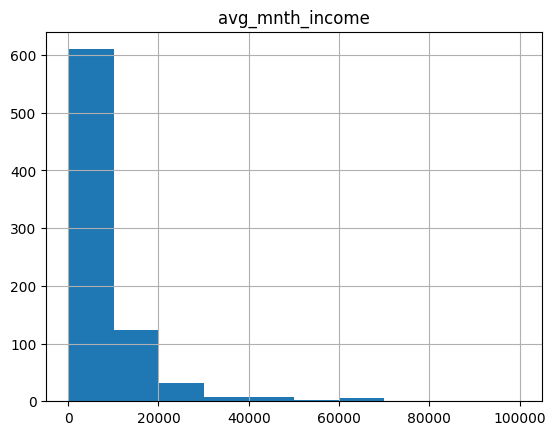

In [ ]:
#average monthly income distribution
nakuru_df['avg_mnth_income'] = nakuru_df['avg_mnth_income'].astype('int')

nakuru_df.hist(column='avg_mnth_income')

Majority of the sample earn an average monthly income below 10,000/=

In [ ]:
#distribution of income by area and insurance use

fig = px.box(nakuru_df, x='area', y='avg_mnth_income')
fig.show()

People living in the urban areas earn a little bit more than those living in the rural areas. 

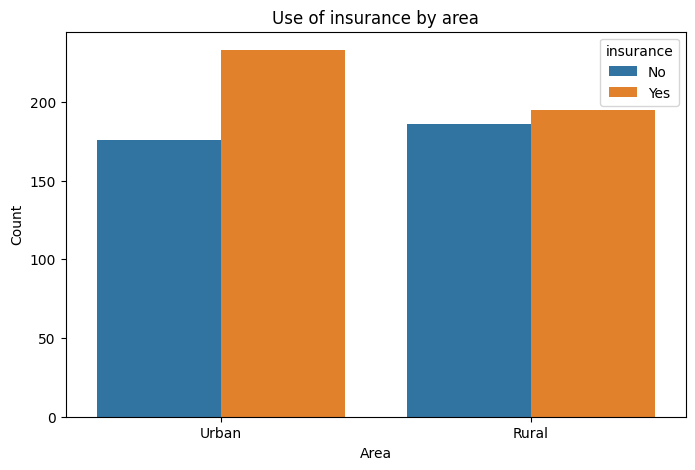

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='area', hue='insurance', data=nakuru_df)
plt.title('Use of insurance by area')
plt.xlabel('Area')
plt.ylabel('Count')
plt.show()

People living in urban areas use insurance more than those living in rural areas.

In [ ]:
income_avg_by_insurance = nakuru_df.groupby('insurance')['avg_mnth_income'].describe()
income_avg_by_insurance

,count,mean,std,min,25%,50%,75%,max
insurance,,,,,,,,
No,362.0,7278.651934,7412.066117,100.0,3000.0,6000.0,9872.0,100000.0
Yes,428.0,12023.834112,11914.344185,500.0,5000.0,9872.0,15000.0,80000.0


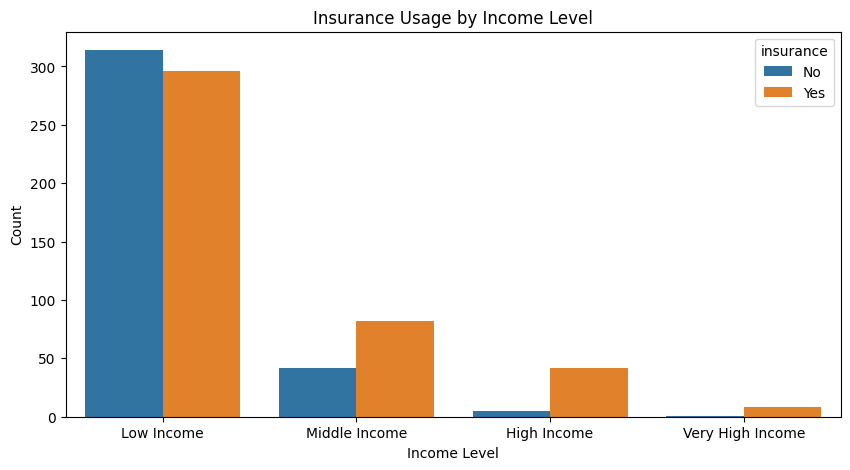

In [ ]:
nakuru_df['income_bins'] = pd.cut(nakuru_df['avg_mnth_income'], bins=[0, 10000, 20000, 50000, nakuru_df['avg_mnth_income'].max()],
                             labels=['Low Income', 'Middle Income', 'High Income', 'Very High Income'])

# Bar plot for insurance usage across income bins
plt.figure(figsize=(10, 5))
sns.countplot(x='income_bins', hue='insurance', data=nakuru_df)
plt.title('Insurance Usage by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.show()

Low income earners are less likely to use insurance products comprared to middle, high, and very high income earners.

In [ ]:
nakuru_df = nakuru_df.rename({'total_exp_per_moth':'total_exp_per_month'}, axis=1)
nakuru_df['total_exp_per_month'] = nakuru_df['total_exp_per_month'].astype('int')

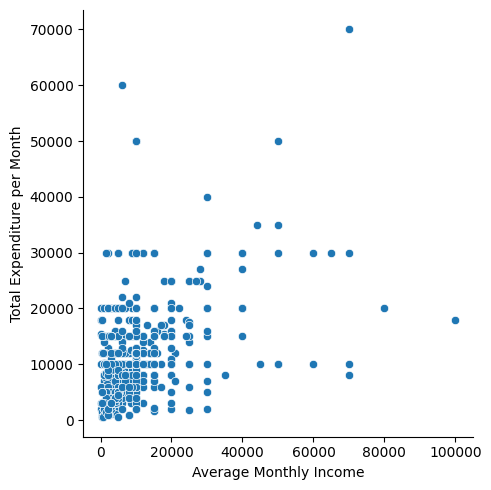

In [ ]:
#avg income vs total expenditure

g = sns.relplot(data=nakuru_df, x='avg_mnth_income', y='total_exp_per_month')
g.set_axis_labels("Average Monthly Income", "Total Expenditure per Month")
plt.show()

Most of the house holds live within their wage. There are a few who either spend above or below their income level.

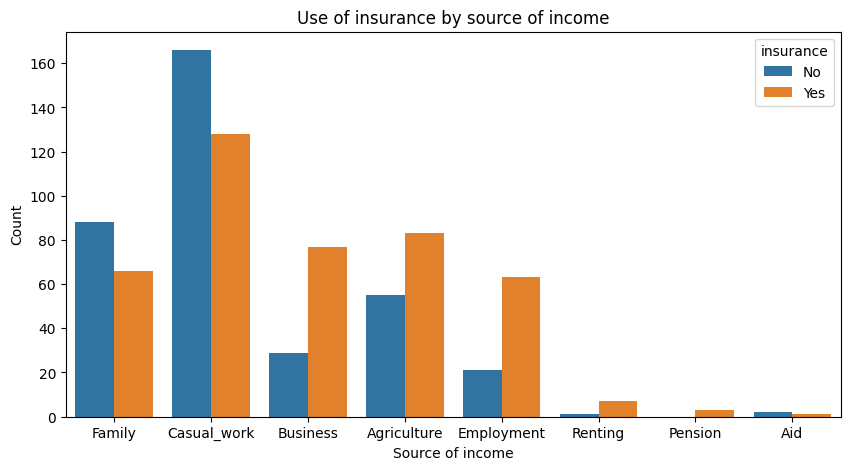

In [ ]:
#insurance use vs source of income

plt.figure(figsize=(10, 5))
sns.countplot(x='income_source', hue='insurance', data=nakuru_df)
plt.title('Use of insurance by source of income')
plt.xlabel('Source of income')
plt.ylabel('Count')
plt.show()

People with some sort of consistent employment(business, agriculture, etc) are more likely to use insurance, whereas those who depend on casual work or help for income are less likely to use insurance.

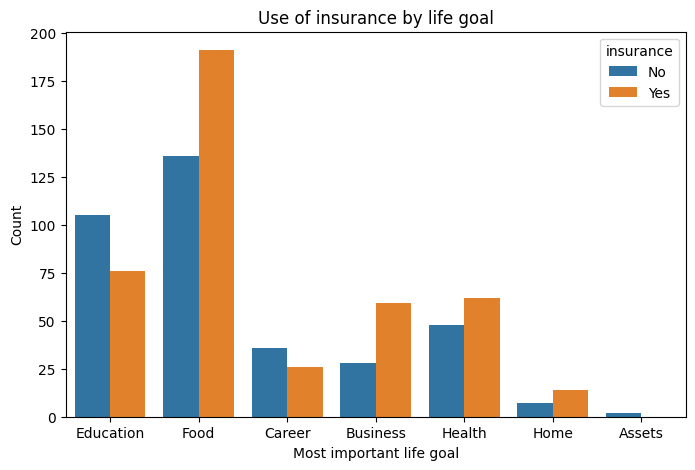

In [ ]:
#insurance use by life goal
plt.figure(figsize=(8, 5))

sns.countplot(x='most_important_life_goal', hue='insurance', data=nakuru_df)
plt.title('Use of insurance by life goal')
plt.xlabel('Most important life goal')
plt.ylabel('Count')
plt.show()

The households whose main goals are to put food on the table, improve business, buy land or build a home, and cater for health needs, tend to most likely use an insurance product. Households who prioritize furthering of education as well as career tend to least use insurance products.

### Clustering

##### Prepare data for clustering

Drop columns that are not to be used for clustering:

In [46]:
replacements = {"Don't Know": np.nan}

nakuru_df['chronic_illness'] = nakuru_df['chronic_illness'].replace(replacements)

In [ ]:
nakuru_df.drop(columns=['HHNo', 'Clusters', 'income_bins'], inplace=True, axis=1)

Impute the missing values of the average monthly income by the mean value:

In [ ]:
nakuru_df['avg_mnth_income'] = pd.to_numeric(nakuru_df['avg_mnth_income'], errors='coerce')

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
nakuru_df['avg_mnth_income']= imputer.fit_transform(nakuru_df[['avg_mnth_income']])
nakuru_df['avg_mnth_income'].isnull().sum()
nakuru_df['avg_mnth_income'] = nakuru_df['avg_mnth_income'].round(1)

In [ ]:
nakuru_df.isna().sum()

area                        0
age_of_respondent           0
chronic_illness             1
nhif_usage                  0
nssf_usage                  0
most_important_life_goal    6
income_source               0
avg_mnth_income             0
hse_land_loan               0
securities_use              0
nearest_financial_prod      0
land_house_ownership        0
total_exp_per_month         0
electronic_device           0
motorvehicle_ownership      0
livestock_ownership         0
insurance                   0
dtype: int64

In [ ]:
#drop missing values
nakuru_df = nakuru_df.dropna(axis=0)
nakuru_df.isnull().sum()

area                        0
age_of_respondent           0
chronic_illness             0
nhif_usage                  0
nssf_usage                  0
most_important_life_goal    0
income_source               0
avg_mnth_income             0
hse_land_loan               0
securities_use              0
nearest_financial_prod      0
land_house_ownership        0
total_exp_per_month         0
electronic_device           0
motorvehicle_ownership      0
livestock_ownership         0
insurance                   0
dtype: int64

In [ ]:
pd.Series({col:nakuru_df[col].unique() for col in nakuru_df})

area                                                           [Urban, Rural]
age_of_respondent           [16, 27, 22, 29, 32, 35, 31, 67, 42, 38, 24, 3...
chronic_illness                                                     [No, Yes]
nhif_usage                                                          [No, Yes]
nssf_usage                                                          [No, Yes]
most_important_life_goal    [Education, Food, Career, Business, Health, Ho...
income_source               [Family, Casual_work, Business, Agriculture, E...
avg_mnth_income             [8000.0, 2000.0, 9872.0, 4000.0, 10000.0, 1000...
hse_land_loan                                                       [No, Yes]
securities_use                                                      [No, Yes]
nearest_financial_prod                              [MMoney, Bank, Insurance]
land_house_ownership                                                [No, Yes]
total_exp_per_month         [7000, 20000, 10000, 5000, 1000, 300

In [ ]:
columns = nakuru_df.select_dtypes(include=('object', 'bool')).columns
columns

Index(['area', 'chronic_illness', 'nhif_usage', 'nssf_usage',
       'most_important_life_goal', 'income_source', 'hse_land_loan',
       'securities_use', 'nearest_financial_prod', 'land_house_ownership',
       'electronic_device', 'motorvehicle_ownership', 'livestock_ownership',
       'insurance'],
      dtype='object')

In [ ]:
nakuru_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 0 to 794
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   area                      789 non-null    object 
 1   age_of_respondent         789 non-null    int64  
 2   chronic_illness           789 non-null    object 
 3   nhif_usage                789 non-null    object 
 4   nssf_usage                789 non-null    object 
 5   most_important_life_goal  789 non-null    object 
 6   income_source             789 non-null    object 
 7   avg_mnth_income           789 non-null    float64
 8   hse_land_loan             789 non-null    object 
 9   securities_use            789 non-null    object 
 10  nearest_financial_prod    789 non-null    object 
 11  land_house_ownership      789 non-null    object 
 12  total_exp_per_month       789 non-null    int64  
 13  electronic_device         789 non-null    object 
 14  motorvehicle_ow

In [ ]:
nakuru_df.reset_index(drop=True)

,area,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,most_important_life_goal,income_source,avg_mnth_income,hse_land_loan,securities_use,nearest_financial_prod,land_house_ownership,total_exp_per_month,electronic_device,motorvehicle_ownership,livestock_ownership,insurance
0,Urban,16,No,No,No,Education,Family,8000.0,No,No,MMoney,No,7000,No,No,False,No
1,Urban,27,No,Yes,Yes,Food,Family,2000.0,No,No,MMoney,No,20000,Yes,Yes,False,Yes
2,Rural,22,No,No,No,Food,Casual_work,9872.0,No,No,MMoney,No,10000,No,Yes,False,No
3,Rural,29,No,No,No,Career,Family,9872.0,No,Yes,MMoney,No,20000,No,No,False,No
4,Urban,32,No,No,No,Career,Casual_work,8000.0,No,No,MMoney,No,10000,No,No,False,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,Urban,40,Yes,No,No,Health,Business,8000.0,No,No,MMoney,No,6000,No,No,False,No
785,Urban,31,No,No,No,Health,Family,7000.0,No,No,MMoney,No,25000,No,No,False,No
786,Urban,28,No,No,Yes,Food,Family,3000.0,No,No,MMoney,No,15000,Yes,No,False,Yes
787,Urban,46,No,No,No,Food,Casual_work,12000.0,No,No,MMoney,Yes,10000,Yes,No,False,No


In [ ]:
nakuru_dff = nakuru_df.copy()

Scale the numerical columns:

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(nakuru_dff[['age_of_respondent', 'avg_mnth_income', 'total_exp_per_month']])

In [ ]:
# joblib.dump(scaler, 'scaler.joblib')

In [ ]:
nakuru_dff[['age_of_respondent', 'avg_mnth_income', 'total_exp_per_month']] = scaled_data

In [ ]:
nakuru_dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 0 to 794
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   area                      789 non-null    object 
 1   age_of_respondent         789 non-null    float64
 2   chronic_illness           789 non-null    object 
 3   nhif_usage                789 non-null    object 
 4   nssf_usage                789 non-null    object 
 5   most_important_life_goal  789 non-null    object 
 6   income_source             789 non-null    object 
 7   avg_mnth_income           789 non-null    float64
 8   hse_land_loan             789 non-null    object 
 9   securities_use            789 non-null    object 
 10  nearest_financial_prod    789 non-null    object 
 11  land_house_ownership      789 non-null    object 
 12  total_exp_per_month       789 non-null    float64
 13  electronic_device         789 non-null    object 
 14  motorvehicle_ow

In [ ]:
nakuru_dff.reset_index(drop=True, inplace=True)

In [ ]:
categorical = ['most_important_life_goal', 'area', 'income_source', 'nearest_financial_prod']

encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(nakuru_dff[categorical])
one_hot_df = pd.DataFrame(encoded, 
                          columns=encoder.get_feature_names_out(categorical))
print(one_hot_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   most_important_life_goal_Assets     789 non-null    float64
 1   most_important_life_goal_Business   789 non-null    float64
 2   most_important_life_goal_Career     789 non-null    float64
 3   most_important_life_goal_Education  789 non-null    float64
 4   most_important_life_goal_Food       789 non-null    float64
 5   most_important_life_goal_Health     789 non-null    float64
 6   most_important_life_goal_Home       789 non-null    float64
 7   area_Rural                          789 non-null    float64
 8   area_Urban                          789 non-null    float64
 9   income_source_Agriculture           789 non-null    float64
 10  income_source_Aid                   789 non-null    float64
 11  income_source_Business              789 non-n

In [ ]:
# joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [ ]:
one_hot_df.isnull().sum()

most_important_life_goal_Assets       0
most_important_life_goal_Business     0
most_important_life_goal_Career       0
most_important_life_goal_Education    0
most_important_life_goal_Food         0
most_important_life_goal_Health       0
most_important_life_goal_Home         0
area_Rural                            0
area_Urban                            0
income_source_Agriculture             0
income_source_Aid                     0
income_source_Business                0
income_source_Casual_work             0
income_source_Employment              0
income_source_Family                  0
income_source_Pension                 0
income_source_Renting                 0
nearest_financial_prod_Bank           0
nearest_financial_prod_Insurance      0
nearest_financial_prod_MMoney         0
dtype: int64

In [ ]:
nakuru_dff.drop(categorical, axis=1, inplace=True)

In [ ]:
nakuru_dff.isna().sum()

age_of_respondent         0
chronic_illness           0
nhif_usage                0
nssf_usage                0
avg_mnth_income           0
hse_land_loan             0
securities_use            0
land_house_ownership      0
total_exp_per_month       0
electronic_device         0
motorvehicle_ownership    0
livestock_ownership       0
insurance                 0
dtype: int64

In [ ]:
nakuru_dff = pd.concat([nakuru_dff, one_hot_df], axis=1)

nakuru_dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age_of_respondent                   789 non-null    float64
 1   chronic_illness                     789 non-null    object 
 2   nhif_usage                          789 non-null    object 
 3   nssf_usage                          789 non-null    object 
 4   avg_mnth_income                     789 non-null    float64
 5   hse_land_loan                       789 non-null    object 
 6   securities_use                      789 non-null    object 
 7   land_house_ownership                789 non-null    object 
 8   total_exp_per_month                 789 non-null    float64
 9   electronic_device                   789 non-null    object 
 10  motorvehicle_ownership              789 non-null    object 
 11  livestock_ownership                 789 non-n

In [ ]:
nakuru_dff.reset_index(drop=True, inplace=True)

In [ ]:
nakuru_dff.isna().sum()

age_of_respondent                     0
chronic_illness                       0
nhif_usage                            0
nssf_usage                            0
avg_mnth_income                       0
hse_land_loan                         0
securities_use                        0
land_house_ownership                  0
total_exp_per_month                   0
electronic_device                     0
motorvehicle_ownership                0
livestock_ownership                   0
insurance                             0
most_important_life_goal_Assets       0
most_important_life_goal_Business     0
most_important_life_goal_Career       0
most_important_life_goal_Education    0
most_important_life_goal_Food         0
most_important_life_goal_Health       0
most_important_life_goal_Home         0
area_Rural                            0
area_Urban                            0
income_source_Agriculture             0
income_source_Aid                     0
income_source_Business                0


In [ ]:
pd.Series({col:nakuru_dff[col].unique() for col in nakuru_dff})

age_of_respondent                     [-1.3570120175746498, -0.6798713690073879, -0....
chronic_illness                                                               [No, Yes]
nhif_usage                                                                    [No, Yes]
nssf_usage                                                                    [No, Yes]
avg_mnth_income                       [-0.17832794077424063, -0.756866792944199, 0.0...
hse_land_loan                                                                 [No, Yes]
securities_use                                                                [No, Yes]
land_house_ownership                                                          [No, Yes]
total_exp_per_month                   [-0.49301628319040974, 1.1443849235005525, -0....
electronic_device                                                             [No, Yes]
motorvehicle_ownership                                                        [No, Yes]
livestock_ownership             

In [ ]:
# joblib.dump(encoder, 'encoder.joblib')

In [ ]:
# nakuru_dff.drop(columns='index', inplace=True)
# nakuru_dff.reset_index(drop=True)

In [ ]:
result = [x for x in columns if x not in categorical]


for col in result:
   nakuru_dff[col] = nakuru_dff[col].astype(bool)

nakuru_dff.head()

,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,avg_mnth_income,hse_land_loan,securities_use,land_house_ownership,total_exp_per_month,electronic_device,...,income_source_Aid,income_source_Business,income_source_Casual_work,income_source_Employment,income_source_Family,income_source_Pension,income_source_Renting,nearest_financial_prod_Bank,nearest_financial_prod_Insurance,nearest_financial_prod_MMoney
0,-1.357012,True,True,True,-0.178328,True,True,True,-0.493016,True,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.679871,True,True,True,-0.756867,True,True,True,1.144385,True,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.987663,True,True,True,0.002176,True,True,True,-0.115154,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.556755,True,True,True,0.002176,True,True,True,1.144385,True,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.372080,True,True,True,-0.178328,True,True,True,-0.115154,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# nakuru_dff.drop('Clusters', axis=1, inplace=True)

In [ ]:
num_column_indices = [0, 3, 5]

cat_column_indices = []
for i in range(len(nakuru_dff.columns)):
        if i not in num_column_indices:
            cat_column_indices.append(i)

for i in [2, 3, 4, 5, 6, 7]:
    model = KPrototypes(n_clusters=i, init='Huang', random_state=42, n_jobs=-1)
    clusters = model.fit_predict(nakuru_dff, categorical=cat_column_indices)

    score = silhouette_score(nakuru_dff, clusters, metric='euclidean')
    print("-------------------------------------------------")
    print('Cost: ', model.cost_)
    print('Silhoutte Score: ', score)
    print("Model trained and saved successfully. Number of samples in each cluster:")
    # for i in range(n_clusters):
    print(f"Cluster {i}: {sum(clusters == i)}")

-------------------------------------------------
Cost:  865.526410617654
Silhoutte Score:  0.19635907744652223
Model trained and saved successfully. Number of samples in each cluster:
Cluster 2: 0
-------------------------------------------------
Cost:  746.4476814940949
Silhoutte Score:  0.0772473426434299
Model trained and saved successfully. Number of samples in each cluster:
Cluster 3: 0
-------------------------------------------------
Cost:  684.0251218872304
Silhoutte Score:  0.11201076625081392
Model trained and saved successfully. Number of samples in each cluster:
Cluster 4: 0
-------------------------------------------------
Cost:  639.51193119974
Silhoutte Score:  0.07195276912680686
Model trained and saved successfully. Number of samples in each cluster:
Cluster 5: 0
-------------------------------------------------
Cost:  614.5723144880583
Silhoutte Score:  0.04909439376247161
Model trained and saved successfully. Number of samples in each cluster:
Cluster 6: 0
---------

In [ ]:
model = KPrototypes(n_clusters=5, init='Huang', random_state=42, n_jobs=-1)
clusters = model.fit_predict(nakuru_dff, categorical=cat_column_indices)

In [ ]:
# joblib.dump(model, 'new_model.joblib')

['new_model.joblib']

In [ ]:
len(clusters)

789

In [ ]:
# nakuru_df.drop(columns=['hse_land_loan', 'securities_use', 'nearest_financial_prod', 'nssf_usage'], inplace=True)

In [ ]:
nakuru_df['Clusters'] = clusters

nakuru_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 0 to 794
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   area                      789 non-null    object 
 1   age_of_respondent         789 non-null    int64  
 2   chronic_illness           789 non-null    object 
 3   nhif_usage                789 non-null    object 
 4   nssf_usage                789 non-null    object 
 5   most_important_life_goal  789 non-null    object 
 6   income_source             789 non-null    object 
 7   avg_mnth_income           789 non-null    float64
 8   hse_land_loan             789 non-null    object 
 9   securities_use            789 non-null    object 
 10  nearest_financial_prod    789 non-null    object 
 11  land_house_ownership      789 non-null    object 
 12  total_exp_per_month       789 non-null    int64  
 13  electronic_device         789 non-null    object 
 14  motorvehicle_ow

In [ ]:
cluster_4 = nakuru_df[nakuru_df['Clusters'] == 4]
cluster_4.head()

,area,age_of_respondent,chronic_illness,nhif_usage,nssf_usage,most_important_life_goal,income_source,avg_mnth_income,hse_land_loan,securities_use,nearest_financial_prod,land_house_ownership,total_exp_per_month,electronic_device,motorvehicle_ownership,livestock_ownership,insurance,Clusters
3,Rural,29,No,No,No,Career,Family,9872.0,No,Yes,MMoney,No,20000,No,No,False,No,4
5,Rural,35,No,No,No,Career,Casual_work,4000.0,No,No,MMoney,Yes,5000,No,No,True,No,4
13,Rural,30,No,No,No,Health,Agriculture,5000.0,No,No,MMoney,No,4000,No,No,True,No,4
16,Rural,17,No,No,No,Food,Casual_work,2000.0,No,No,MMoney,No,5000,No,No,True,No,4
20,Rural,25,No,No,No,Food,Agriculture,1000.0,No,No,MMoney,Yes,8200,No,No,False,No,4


In [ ]:
# Add cluster assignments to original data

# Create business rules for insurance products
def recommend_insurance(df):
    cluster_based_products = []
    if df['avg_mnth_income'] > 50000:  # High income cluster
        cluster_based_products.extend(['Life Insurance', 'Investment-linked Insurance'])
    elif df['avg_mnth_income'] > 15000:  # Medium income cluster
        cluster_based_products.append('Life Insurance')
    else:  # Low income cluster
        cluster_based_products.append('Basic Insurance Package')

    # Add specific product recommendations based on characteristics
    if df['chronic_illness'] == "Yes":
        cluster_based_products.append("Health Insurance")
    if df['motorvehicle_ownership'] == "Yes":
        cluster_based_products.append("Motor Insurance")
    if df['land_house_ownership'] == "Yes":
        cluster_based_products.append("Property Insurance")
    if df['livestock_ownership'] == "True":
        cluster_based_products.append("Livestock Insurance")
    if df['age_of_respondent'] > 50:
        cluster_based_products.append("Retirement Insurance")

    return list(set(cluster_based_products))

# Apply business rules
# for index, row in nakuru_dff.iterrows():
nakuru_df['Recommended_Products'] = nakuru_df.apply(recommend_insurance, axis=1)

# Display cluster insights
for cluster in list(set(clusters)):
    cluster_data = nakuru_df[nakuru_df['Clusters'] == cluster]
    print(f"\
Cluster {cluster} Profile:")
    print(f"Size: {len(cluster_data)} customers")
    print("Top Insurance Products:")
    print(cluster_data['Recommended_Products'].value_counts())
    print("Average Income:", round(cluster_data['avg_mnth_income'].mean(), 0))
    print("Average Age:", round(cluster_data['age_of_respondent'].mean(), 0))
    print("---")

Cluster 0 Profile:
Size: 95 customers
Top Insurance Products:
Recommended_Products
[Property Insurance, Retirement Insurance, Basic Insurance Package]                                          45
[Property Insurance, Retirement Insurance, Health Insurance, Basic Insurance Package]                        25
[Retirement Insurance, Basic Insurance Package]                                                               9
[Property Insurance, Basic Insurance Package, Health Insurance, Retirement Insurance, Motor Insurance]        4
[Property Insurance, Retirement Insurance, Life Insurance, Health Insurance]                                  3
[Retirement Insurance, Health Insurance, Basic Insurance Package]                                             2
[Life Insurance, Retirement Insurance]                                                                        2
[Property Insurance, Health Insurance, Life Insurance, Retirement Insurance, Motor Insurance]                 2
[Motor Insurance, Ret

In [ ]:
clf_kp = LGBMClassifier()
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    cv_scores_kp = cross_val_score(clf_kp, nakuru_dff, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.9403591452261756


In [ ]:
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    classifier = clf_kp.fit(nakuru_dff, clusters)

In [87]:
joblib.dump(classifier, 'classifier.joblib')

['classifier.joblib']